<a href="https://colab.research.google.com/github/silyones/learning_git/blob/main/ctgan_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CHANGES MADE FROM PRIOR CODE
1. Drop duplicates (remove repeated rows).

2. Fill missing values with median (works well for numeric fraud data since it’s less sensitive to outliers than mean).

1. Feature Selection using SelectKBest with ANOVA F-values.

2. Select top 14 features.

3. Plot bar chart of feature importance.

4. Display class distribution (Normal vs Fraud) after selection.

5. Show reduced dataset.

1. Drop duplicates excluding Class → Prevents losing fraud samples that share the same features as normal ones.

2. Fill missing values with median → Keeps all rows by replacing NaNs instead of dropping them.

3. Scale Time and Amount with RobustScaler → Normalizes these features while resisting the effect of outliers.1.

In [7]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# Step 1: Load dataset
df = pd.read_csv("creditcard1.csv")

# Check initial class distribution
print("Initial class distribution:")
print(df['Class'].value_counts())

# Step 2: Data Cleaning

## 2.1 Drop duplicates (but ignore 'Class' when comparing duplicates)
df = df.drop_duplicates(subset=df.columns.difference(['Class']))

## 2.2 Fill missing values with median
df = df.fillna(df.median(numeric_only=True))

# Step 2: Scaling
scaler = RobustScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

# Final check after cleaning
print("\nClass distribution after cleaning:")
print(df['Class'].value_counts())

print("\nData after scaling:")
print(df.head())


Initial class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Class distribution after cleaning:
Class
0    283253
1       473
Name: count, dtype: int64

Data after scaling:
       Time        V1        V2        V3        V4        V5        V6  \
0 -0.995290 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1 -0.995290  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2 -0.995279 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3 -0.995279 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4 -0.995267 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436 -1.387024 

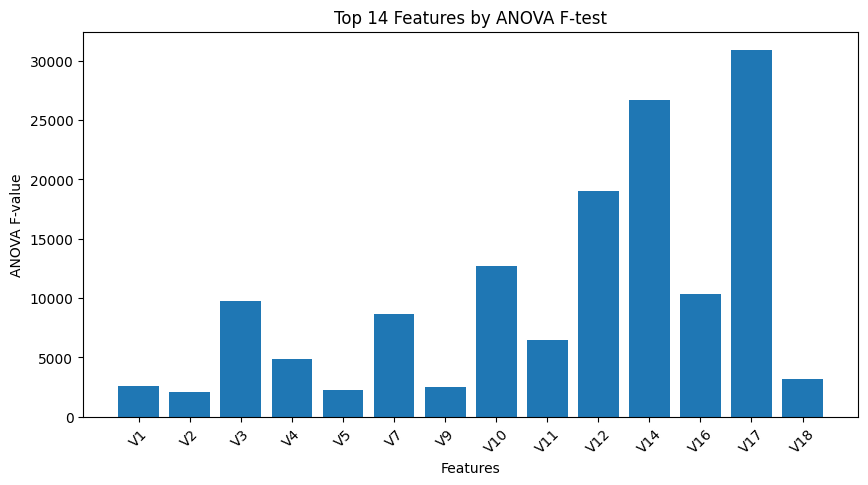

Class distribution after feature selection:
 Class
0    283253
1       473
Name: count, dtype: int64

Reduced Data (Top 5 rows):
          V1        V2        V3        V4        V5        V7        V9  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.239599  0.363787   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.078803 -0.255425   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  0.791461 -1.514654   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  0.237609 -1.387024   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.592941  0.817739   

        V10       V11       V12       V14       V16       V17       V18  Class  
0  0.090794 -0.551600 -0.617801 -0.311169 -0.470401  0.207971  0.025791      0  
1 -0.166974  1.612727  1.065235 -0.143772  0.463917 -0.114805 -0.183361      0  
2  0.207643  0.624501  0.066084 -0.165946 -2.890083  1.109969 -0.121359      0  
3 -0.054952 -0.226487  0.178228 -0.287924 -1.059647 -0.684093  1.965775      0  
4  0.753074 -0

In [9]:
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Apply SelectKBest (ANOVA F-test)
selector = SelectKBest(score_func=f_classif, k=14)
X_new = selector.fit_transform(X, y)

# Get selected feature names & scores
selected_features = X.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]

# Bar chart for feature importance
plt.figure(figsize=(10,5))
plt.bar(selected_features, scores)
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("ANOVA F-value")
plt.title("Top 14 Features by ANOVA F-test")
plt.show()

# Create reduced dataframe
reduced_data = pd.DataFrame(X_new, columns=selected_features)
reduced_data['Class'] = y.values

# Show class counts after feature selection
print("Class distribution after feature selection:\n", reduced_data['Class'].value_counts())

# Display reduced data
print("\nReduced Data (Top 5 rows):\n", reduced_data.head())


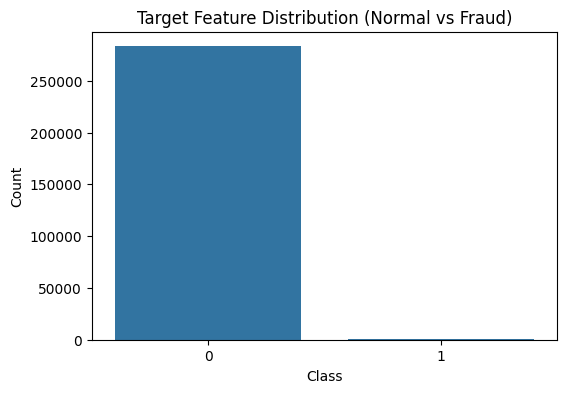

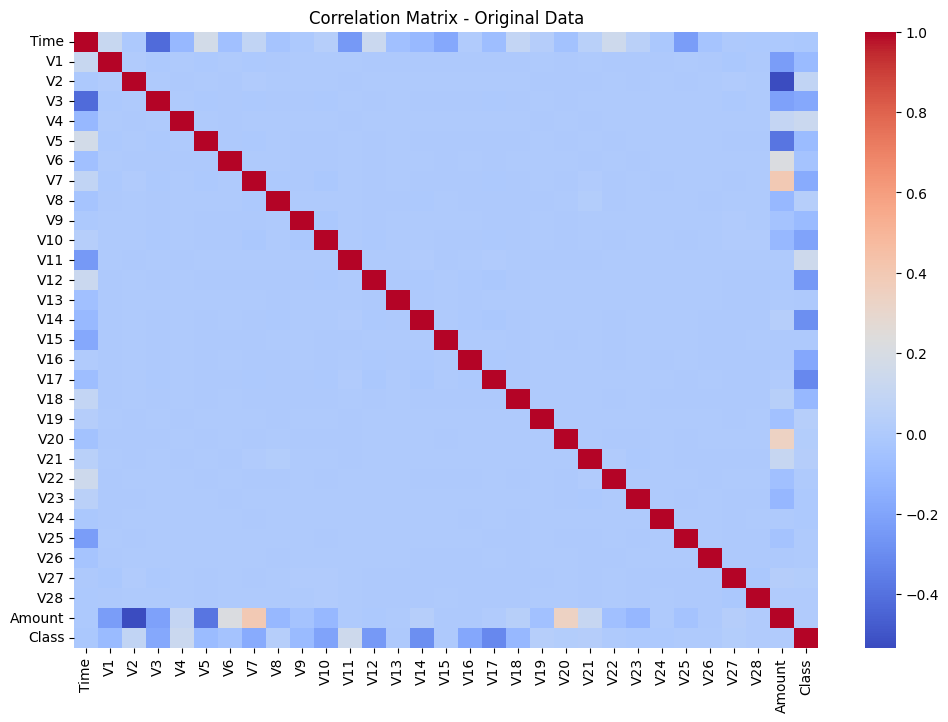

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target feature distribution (Class column)
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Target Feature Distribution (Normal vs Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Correlation matrix for original data
plt.figure(figsize=(12,8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix - Original Data")
plt.show()


1. Uses stratify=y so that fraud/normal ratio remains consistent in all splits.

Splits into:

Train: 70%

Validation: 15%

Test: 15%

In [13]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Step 4: Split data into Train, Validation, and Test
# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print class distribution in each split
print("Training set class distribution:")
print(y_train.value_counts())

print("\nValidation set class distribution:")
print(y_val.value_counts())

print("\nTest set class distribution:")
print(y_test.value_counts())


Training set class distribution:
Class
0    198277
1       331
Name: count, dtype: int64

Validation set class distribution:
Class
0    42488
1       71
Name: count, dtype: int64

Test set class distribution:
Class
0    42488
1       71
Name: count, dtype: int64


why it’s good:

1. Fraud ratio is preserved → Original ratio was about 0.167% fraud, and your splits have almost the same ratio.

2. Even distribution → Fraud and normal transactions are proportionally spread across train, validation, and test sets.

3. No leakage risk → Same transaction doesn’t appear in more than one set.

4. Balanced data for evaluation → Both validation and test sets have enough fraud cases (71 each) to check model performance.